In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

from imblearn.over_sampling import RandomOverSampler

from metric_utils import get_data_metrics, get_model_metrics, sort_model_metrics, get_model_metric_comparison

In [2]:
## Globals
COLORS = sns.palettes.color_palette('colorblind')
RANDOM_STATE = 42
TEST_SIZE = 0.33
ITER = 2500
N_JOBS = -1

if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  data_path = 'drive/MyDrive/BigDataMaster/TFM/data/creditcard.csv'
elif os.getenv('CONTAINER_BASE_DIR'):
  data_path = '../data/creditcard.csv'  
else:
  data_path = '../../data/creditcard.csv'

In [3]:
df = pd.read_csv(data_path)
X, y = df.drop(columns=['Class']), df['Class']

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
## before resampling
print(f'''Dataset Shape
    rows:    {df.shape[0]:,}
    columns: {df.shape[1]}
Classes unbalance in number
    Non Fraud (0): {df['Class'].value_counts()[0]:,}
    Fraud (1):     {df['Class'].value_counts()[1]:,}
Classes unbalance in percentage (%)
    Non Fraud (0): {(df['Class'].value_counts() / df.shape[0] * 100)[0]:.4f}%
    Fraud (1):     {(df['Class'].value_counts() / df.shape[0] * 100)[1]:.4f}%
''')

Dataset Shape
    rows:    284,807
    columns: 31
Classes unbalance in number
    Non Fraud (0): 284,315
    Fraud (1):     492
Classes unbalance in percentage (%)
    Non Fraud (0): 99.8273%
    Fraud (1):     0.1727%



# Running the model manually without resampling

In [5]:
EXP_ID = 'ROS + LogReg'

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [6]:
get_data_metrics(y_train, 'train', EXP_ID), get_data_metrics(y_train, 'test', EXP_ID)

([{'class': 0,
   'count': 190477,
   'percent': 0.9982024944974321,
   'subset': 'train',
   'is_resampled': False,
   'exp_id': 'ROS + LogReg'},
  {'class': 1,
   'count': 343,
   'percent': 0.001797505502567865,
   'subset': 'train',
   'is_resampled': False,
   'exp_id': 'ROS + LogReg'}],
 [{'class': 0,
   'count': 190477,
   'percent': 0.9982024944974321,
   'subset': 'test',
   'is_resampled': False,
   'exp_id': 'ROS + LogReg'},
  {'class': 1,
   'count': 343,
   'percent': 0.001797505502567865,
   'subset': 'test',
   'is_resampled': False,
   'exp_id': 'ROS + LogReg'}])

In [7]:
lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=ITER, n_jobs=N_JOBS)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
lr_metrics = get_model_metrics(y_test, y_pred, EXP_ID)
lr_metrics

{'is_resampled': False,
 'exp_id': 'ROS + LogReg',
 'f_score': 0.7031249999999999,
 'recall': 0.6040268456375839,
 'precision': 0.8411214953271028,
 'g_mean': 0.7771212377436191,
 'roc_auc_score': 0.801922841178092}

# Running Model with the data resampled

In [8]:
ros = RandomOverSampler(random_state=RANDOM_STATE)
X_resampled, y_resampled = ros.fit_resample(X, y)

## comparing some DataFrame metrics before and after resampling
data_metrics = get_data_metrics(y, 'main', EXP_ID, False) + \
  get_data_metrics(y_resampled, 'main', EXP_ID, True)

df_data_metrics = pd.DataFrame(data_metrics)
df_data_metrics

,class,count,percent,subset,is_resampled,exp_id
0,0,284315,0.998273,main,False,ROS + LogReg
1,1,492,0.001727,main,False,ROS + LogReg
2,0,284315,0.500000,main,True,ROS + LogReg
3,1,284315,0.500000,main,True,ROS + LogReg


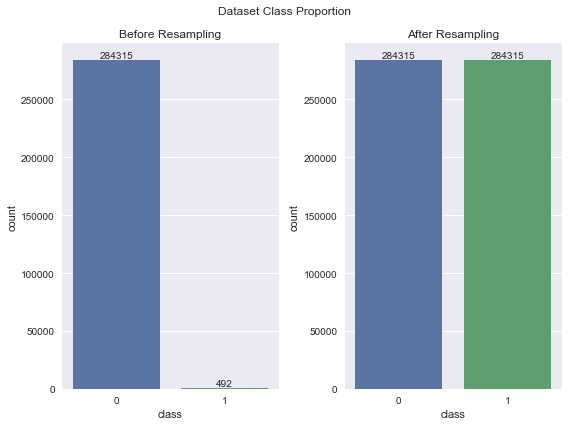

In [9]:
_ = plt.figure(figsize=[8,6])
plt.suptitle('Dataset Class Proportion')

before = df_data_metrics[~df_data_metrics['is_resampled']]
after = df_data_metrics[df_data_metrics['is_resampled']]

plt.subplot(1,2,1)
ax = sns.barplot(
    data=before,
    x='class',
    y='count')
for container in ax.containers:
  ax.bar_label(container)
plt.title('Before Resampling')

plt.subplot(1,2,2)
ax = sns.barplot(
    data=after,
    x='class',
    y='count')
for container in ax.containers:
    ax.bar_label(container)
plt.title('After Resampling')

plt.tight_layout()

In [10]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
    X_resampled, y_resampled, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [11]:
## comparing some DataFrame metrics before and after resampling
# it can be noted that the minority class (fraud) grown significantly
# the proportion of the two clases was maintained
data_metrics = data_metrics + \
    get_data_metrics(y_train, 'train', EXP_ID, False) + \
    get_data_metrics(y_train_resampled, 'train', EXP_ID, True) + \
    get_data_metrics(y_test, 'test', EXP_ID, False) + \
    get_data_metrics(y_test_resampled, 'test', EXP_ID, True)

df_data_metrics = pd.DataFrame(data_metrics)
df_data_metrics

,class,count,percent,subset,is_resampled,exp_id
0,0,284315,0.998273,main,False,ROS + LogReg
1,1,492,0.001727,main,False,ROS + LogReg
2,0,284315,0.500000,main,True,ROS + LogReg
3,1,284315,0.500000,main,True,ROS + LogReg
4,0,190477,0.998202,train,False,ROS + LogReg
5,1,343,0.001798,train,False,ROS + LogReg
6,0,190540,0.500129,train,True,ROS + LogReg
7,1,190442,0.499871,train,True,ROS + LogReg
8,1,149,0.001585,test,False,ROS + LogReg
9,0,93838,0.998415,test,False,ROS + LogReg


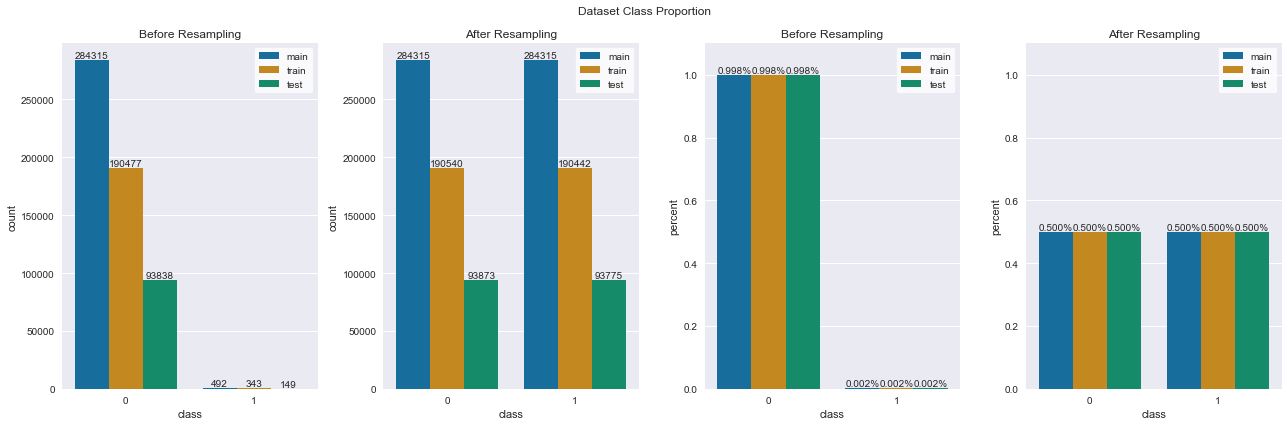

In [12]:
_ = plt.figure(figsize=[18,6])
plt.suptitle('Dataset Class Proportion')

before = df_data_metrics[~df_data_metrics['is_resampled']]
after = df_data_metrics[df_data_metrics['is_resampled']]

## magtitudes
# before
plt.subplot(1,4,1)
ax = sns.barplot(
    data=before,
    x='class',
    y='count',
    hue='subset',
    palette='colorblind')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Before Resampling')
plt.legend(frameon=True).get_frame().set_color('white')

# after
plt.subplot(1,4,2)
ax = sns.barplot(
    data=after,
    x='class',
    y='count',
    hue='subset',
    palette='colorblind')
for container in ax.containers:
    ax.bar_label(container)
plt.title('After Resampling')
plt.legend(frameon=True).get_frame().set_color('white')

## percentages
FMT = '%.3f%%'

# before
plt.subplot(1,4,3)
ax = sns.barplot(
    data=before,
    x='class',
    y='percent',
    hue='subset',
    palette='colorblind')
for container in ax.containers:
    ax.bar_label(container, fmt=FMT)
plt.title('Before Resampling')
plt.ylim([0,1.1])
plt.legend(frameon=True).get_frame().set_color('white')

# after
plt.subplot(1,4,4)
ax = sns.barplot(
    data=after,
    x='class',
    y='percent',
    hue='subset',
    palette='colorblind')
for container in ax.containers:
    ax.bar_label(container, fmt=FMT)
plt.title('After Resampling')
plt.ylim([0,1.1])
plt.legend(frameon=True).get_frame().set_color('white')

plt.tight_layout()

In [13]:
lr_resampled = LogisticRegression(random_state=RANDOM_STATE, max_iter=ITER, n_jobs=N_JOBS)\
    .fit(X_train_resampled, y_train_resampled)
y_pred_resampled = lr_resampled.predict(X_test_resampled)

lr_metrics_res = get_model_metrics(y_test_resampled, y_pred_resampled, EXP_ID, True)
lr_metrics_res

{'is_resampled': True,
 'exp_id': 'ROS + LogReg',
 'f_score': 0.9365765568567364,
 'recall': 0.9116039755840337,
 'precision': 0.9629558778849292,
 'g_mean': 0.9378709078291536,
 'roc_auc_score': 0.9382493351660505}

In [14]:
df_model_metric = pd.DataFrame([lr_metrics, lr_metrics_res])
df_model_metric

,is_resampled,exp_id,f_score,recall,precision,g_mean,roc_auc_score
0,False,ROS + LogReg,0.703125,0.604027,0.841121,0.777121,0.801923
1,True,ROS + LogReg,0.936577,0.911604,0.962956,0.937871,0.938249


In [15]:
# df_model_metric.info()
df_model_metric.select_dtypes(include='float64').columns

Index(['f_score', 'recall', 'precision', 'g_mean', 'roc_auc_score'], dtype='object')

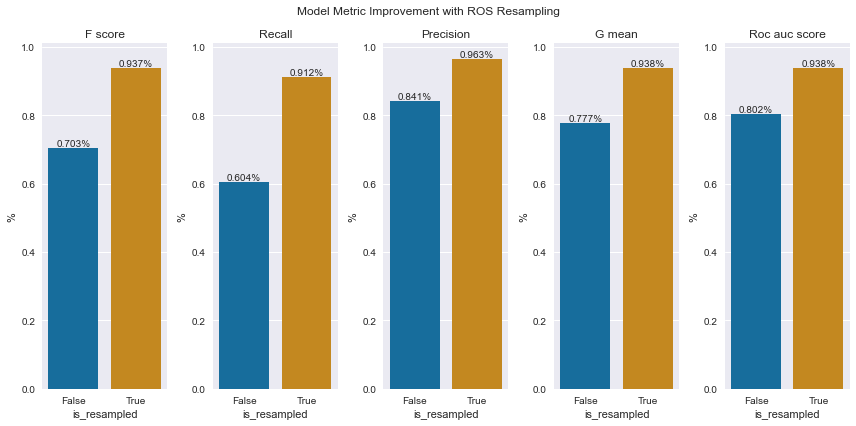

In [16]:
_ = plt.figure(figsize=[12,6])
plt.suptitle('Model Metric Improvement with ROS Resampling')

metric_list = df_model_metric.select_dtypes(include='float64').columns
for i, metric in enumerate(metric_list):
    plt.subplot(1, metric_list.__len__(), i+1)
    ax = sns.barplot(
        data=df_model_metric,
        x='is_resampled',
        y=metric,
        palette='colorblind')
    for container in ax.containers:
        ax.bar_label(container, fmt=FMT)
    ax.set_ylabel('%')
    plt.ylim([0,1.01])
    plt.title(metric.replace('_', ' ').capitalize())
  
plt.tight_layout()